In [24]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, GlobalAveragePooling2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Add, Multiply
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

In [25]:
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
IMAGE_SIZE = (224, 224)
train_path = 'chest_xray/train'
valid_path = 'chest_xray/test'

In [28]:
def residual_block(x, filters, stride, attention=True):
    shortcut = x

    # First convolution
    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolution
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    # Attention Mechanism
    if attention:
        avg_pool = GlobalAveragePooling2D()(x)
        avg_pool = Reshape((1, 1, filters))(avg_pool)
        avg_pool = Conv2D(filters, (1, 1))(avg_pool)
        attention = Multiply()([x, avg_pool])
        x = Add()([x, attention])

    # Shortcut connection
    if stride > 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride)(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [29]:
def create_resatt_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Define the Residual Attention Blocks (RABs)
    for _ in range(3):
        x = residual_block(x, 64, stride=1)
    x = residual_block(x, 128, stride=2)
    for _ in range(2):
        x = residual_block(x, 128, stride=1, attention=False)
    x = residual_block(x, 256, stride=2)
    for _ in range(2):
        x = residual_block(x, 256, stride=1, attention=False)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [30]:
# Create the ResAtt model
model = create_resatt_model(input_shape=(224, 224, 3), num_classes=2)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_78 (Conv2D)          (None, 112, 112, 64)         9472      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_57 (Ba  (None, 112, 112, 64)         256       ['conv2d_78[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_57 (Activation)  (None, 112, 112, 64)         0         ['batch_normalization_57

In [31]:
# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.001)


In [32]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)


In [33]:
# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.4,
    zoom_range=0.4,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [34]:
training_set = train_datagen.flow_from_directory(train_path, target_size=IMAGE_SIZE, batch_size=32, class_mode='categorical')
test_set = test_datagen.flow_from_directory(valid_path, target_size=IMAGE_SIZE, batch_size=32, class_mode='categorical')

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [35]:
# Training the Model
history = model.fit(
    training_set,
    validation_data=test_set,
    epochs=20,  # You can adjust the number of epochs as needed
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set),
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/20
163/163 [==============================] - 415s 3s/step - loss: 0.3923 - accuracy: 0.8234 - val_loss: 2.3779 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/20
163/163 [==============================] - 462s 3s/step - loss: 0.2894 - accuracy: 0.8731 - val_loss: 1.3705 - val_accuracy: 0.4311 - lr: 0.0010
Epoch 3/20
163/163 [==============================] - 499s 3s/step - loss: 0.2511 - accuracy: 0.8913 - val_loss: 9.9338 - val_accuracy: 0.3814 - lr: 0.0010
Epoch 4/20
163/163 [==============================] - 488s 3s/step - loss: 0.2516 - accuracy: 0.8938 - val_loss: 1.7425 - val_accuracy: 0.3670 - lr: 0.0010
Epoch 5/20
163/163 [==============================] - 511s 3s/step - loss: 0.2248 - accuracy: 0.9030 - val_loss: 0.4871 - val_accuracy: 0.7997 - lr: 0.0010
Epoch 6/20
163/163 [==============================] - 459s 3s/step - loss: 0.2281 - accuracy: 0.9049 - val_loss: 0.4359 - val_accuracy: 0.8670 - lr: 0.0010
Epoch 7/20
163/163 [==============================] - 1712s 11s/

In [36]:
from keras.preprocessing import image

img = image.load_img('chest_xray/test/PNEUMONIA/person1_virus_11.jpeg', target_size=IMAGE_SIZE)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = x / 255.0  # Normalize the image
classes = model.predict(img_data)
result = int(classes[0][0])
if result == 0:
    print("Person is Affected By PNEUMONIA")
else:
    print("Result is Normal")


1/1 [==============================] - 0s 430ms/step
Person is Affected By PNEUMONIA


1/1 [==============================] - 0s 270ms/step


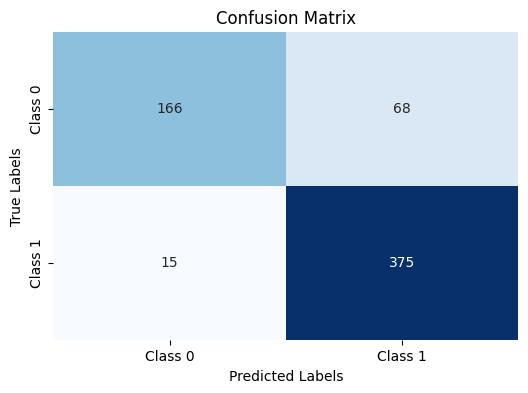

In [37]:
true_labels = []
predicted_labels = []

for i in range(len(test_set)):
    batch = test_set[i]
    images, labels = batch
    predictions = model.predict(images)
    
    true_labels.extend(np.argmax(labels, axis=1))
    predicted_labels.extend(np.argmax(predictions, axis=1))

t_labels = np.array(true_labels)
p_labels = np.array(predicted_labels)

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(conf_matrix)) + 0.5, ['Class 0', 'Class 1'])
plt.yticks(np.arange(len(conf_matrix)) + 0.5, ['Class 0', 'Class 1'])
plt.show()


In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Finding precision and recall
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy   :", accuracy)
precision = precision_score(true_labels, predicted_labels)
print("Precision :", precision)
recall = recall_score(true_labels, predicted_labels)
print("Recall    :", recall)
F1_score = f1_score(true_labels, predicted_labels)
print("F1-score  :", F1_score)

Accuracy   : 0.8669871794871795
Precision : 0.8465011286681715
Recall    : 0.9615384615384616
F1-score  : 0.900360144057623
